In [1]:
import pandas as pd
import numpy as np
import os

pd.set_option('max_columns', None)
pd.set_option('max_rows', 2500)

# loading a couple of libraries for binning and plotting
from scipy.stats import binned_statistic_2d
from mplsoccer.pitch import Pitch, VerticalPitch

# for visualising the matrices
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import xGils.deltaxT as deltaxT

# **Team xT**

Starting very simply, we want to sum up the binned xT for each team per season. This will give us a vector that characterises the attacking threat of a team.

# **Delta xT**

Attacking threat can be measured **directly**: looking at the passes, crosses, dribbles, and shots of a team.

Defending always difficult to measure with **on-the-ball** events data because so much of the art of defending happens **off-the-ball**. Maldini quote: "If I have to make a tackle, I've already made a mistake."

So we use *delta xT* to indirectly probe at the ways in which opposing teams re-direct their threat at a given team, compared to how they play against all other teams, on average. This is *delta xT*.

## **Loading Opta Bayesian xT Data**

In [2]:
%%time

df_opta_xT = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT/Bayesian_Opta_xT.csv')

# converting the timestamp string to a datetime
df_opta_xT['timeStamp'] = pd.to_datetime(df_opta_xT.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df_opta_xT['kickOffDateTime'] = pd.to_datetime(df_opta_xT.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

print (f'{len(df_opta_xT)} rows loaded.\n')

df_opta_xT.head()

3126182 rows loaded.

CPU times: user 14.3 s, sys: 1.47 s, total: 15.8 s
Wall time: 15.9 s


,competition,season,seasonIndex,gameMonthIndex,matchId,playerId,playerName,position,detailedPosition,playerTeamId,minsPlayed,subIn,subOut,replacedReplacingPlayerId,booking,eventType,eventSubType,eventTypeId,x1,y1,x2,y2,gameTime,timeStamp,periodId,homeTeamName,homeTeamId,awayTeamName,awayTeamId,kickOffDateTime,minute,second,x1_m,y1_m,x2_m,y2_m,xT
0,English Premier League,2017/18,1,24212,918893,59966,Alexandre Lacazette,Forward,Striker,3,95,NaN,NaN,NaN,NaN,attack,Pass,1,50.0,50.7,28.8,30.1,0:1,2017-08-11 19:46:04.968,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,1,52.500,34.476,30.240,20.468,-0.003278
1,English Premier League,2017/18,1,24212,918893,156074,Rob Holding,Defender,FullBack,3,67,NaN,1.0,NaN,NaN,attack,Pass,1,29.7,26.7,52.3,21.5,0:2,2017-08-11 19:46:05.554,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,2,31.185,18.156,54.915,14.620,0.003008
2,English Premier League,2017/18,1,24212,918893,37605,Mesut Özil,Forward,AttackingMidfielder,3,95,NaN,NaN,NaN,NaN,attack,Pass,1,52.8,21.3,44.3,20.7,0:5,2017-08-11 19:46:08.554,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,5,55.440,14.484,46.515,14.076,-0.001186
3,English Premier League,2017/18,1,24212,918893,153256,Mohamed Elneny,Midfielder,CentralMidfielder,3,66,NaN,1.0,NaN,NaN,attack,Pass,1,44.0,19.6,50.3,4.2,0:7,2017-08-11 19:46:10.554,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,7,46.200,13.328,52.815,2.856,-0.000542
4,English Premier League,2017/18,1,24212,918893,98745,Héctor Bellerín,Midfielder,RightMidfielder,3,95,NaN,NaN,NaN,NaN,attack,Pass,1,51.0,4.2,70.5,5.0,0:9,2017-08-11 19:46:13.519,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,9,53.550,2.856,74.025,3.400,0.005850


In [3]:
# pass events (inc. crosses)
opta_successful_pass_events = ['2nd Assist','Assist','Chance Created','Cross','Pass']
opta_failed_pass_events = ['Failed Pass','Offside Pass']

# dribble events
opta_successful_dribble_events = ['Dribble']
opta_failed_dribble_events = ['Failed Dribble']

# shot events
opta_successful_shot_events = ['Goal']
opta_failed_shot_events = ['Hit Woodwork','Miss','Missed Penalty','Penalty Saved','Shot Blocked','Shot Saved']

opta_events_successful = opta_successful_pass_events + opta_successful_dribble_events + opta_successful_shot_events
opta_events_relevant = opta_successful_pass_events + opta_failed_pass_events + opta_successful_dribble_events + opta_failed_dribble_events + opta_successful_shot_events + opta_failed_shot_events

opta_events_relevant

['2nd Assist',
 'Assist',
 'Chance Created',
 'Cross',
 'Pass',
 'Failed Pass',
 'Offside Pass',
 'Dribble',
 'Failed Dribble',
 'Goal',
 'Hit Woodwork',
 'Miss',
 'Missed Penalty',
 'Penalty Saved',
 'Shot Blocked',
 'Shot Saved']

---

## **Team xT**

In [16]:
# things we want data for
competition = 'English Premier League'
seasons = ['2017/18','2018/19','2019/20','2020/21']

# just interested in the EPL for this analysis, for the seasons specified above
df_xT = df_opta_xT.loc[(df_opta_xT['competition'] == competition) & (df_opta_xT['season'].isin(seasons))].copy().reset_index(drop=True)

# producing a dataframe for team ref
df_epl_teams = deltaxT.produce_df_teams_ref(df_xT)
df_epl_teams

,teamName,teamId
0,Manchester United,1
1,Leeds United,2
2,Arsenal,3
3,Newcastle United,4
4,Tottenham Hotspur,6
5,Aston Villa,7
6,Chelsea,8
7,Everton,11
8,Leicester City,13
9,Liverpool,14


### **Exploratory Code**

#### Looking at most common coords

In [ ]:
df_opta_xT.groupby(['x1_m','y1_m'])\
        .agg({'playerId':'count'})\
        .reset_index()\
        .rename(columns={'playerId':'freq'})\
        .sort_values('freq', ascending=False)\
        .head(10)

#### Aggregating xT Per Team Per Season

In [12]:
df_xT.groupby(['season','playerTeamId']).agg({'x1_m':'count'}).reset_index()\
    .rename(columns={'x1_m':'numEvents'})\
    .sort_values(['playerTeamId','season'], ascending=[True,True])\
    .head()

,season,playerTeamId,numEvents
0,2017/18,1,36001
20,2018/19,1,34841
40,2019/20,1,35473
60,2020/21,1,35528
61,2020/21,2,34558


### **Initial Look at Team xT**

**Purely grouping and summing per EPL team per season**

> TODO: Could definitely put 10 teams in a bumpy chart

In [5]:
df_team_xT_total = df_xT.groupby(['competition','season','playerTeamId'])\
                    .agg({'xT':np.sum})\
                    .reset_index()\
                    .merge(df_epl_teams, left_on=['playerTeamId'], right_on=['teamId'])\
                    .drop(columns=['playerTeamId'])\
                    [['season','teamName','teamId','xT']]

df_team_xT_total.head()

,season,teamName,teamId,xT
0,2017/18,Manchester United,1,35.969278
1,2018/19,Manchester United,1,37.888261
2,2019/20,Manchester United,1,29.991356
3,2020/21,Manchester United,1,34.404555
4,2017/18,Arsenal,3,42.259737


### **Function to sum xT into bins per team**

> What should this function look like?

> Probably should be nice and clean, producing a team's xT vector for that season

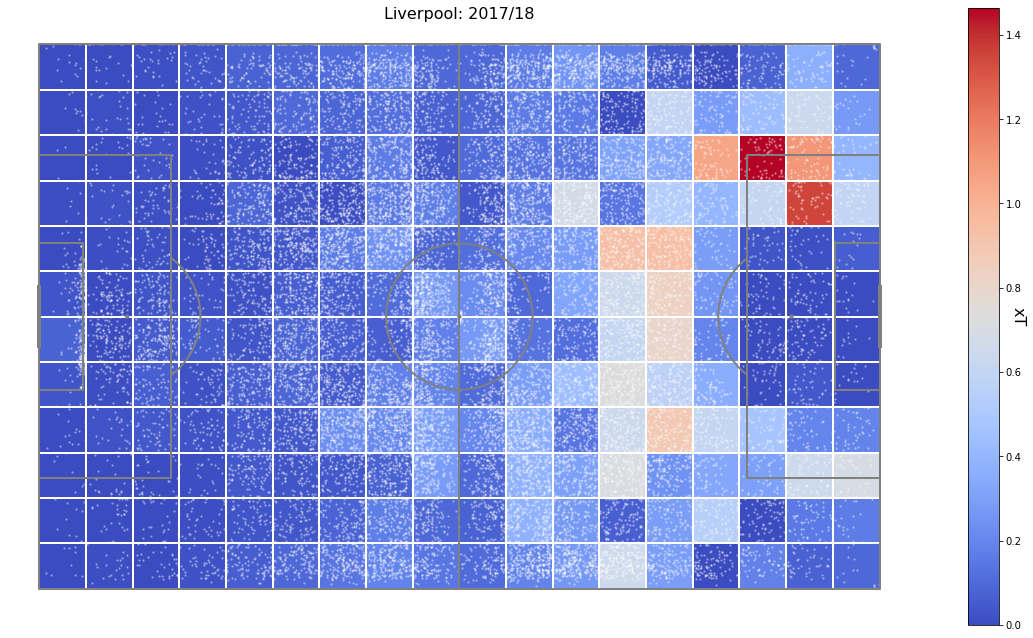

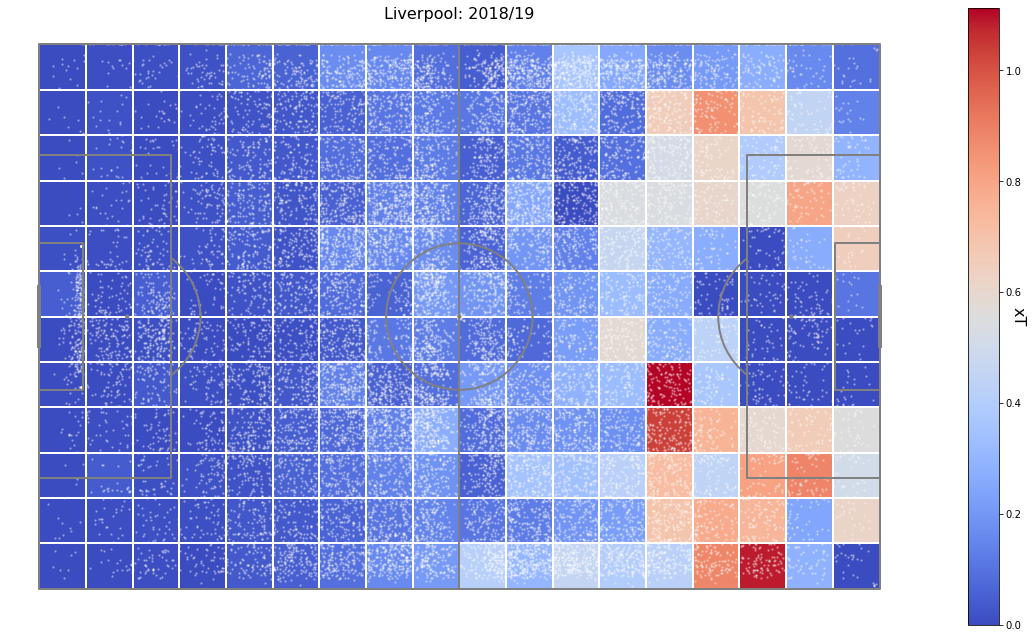

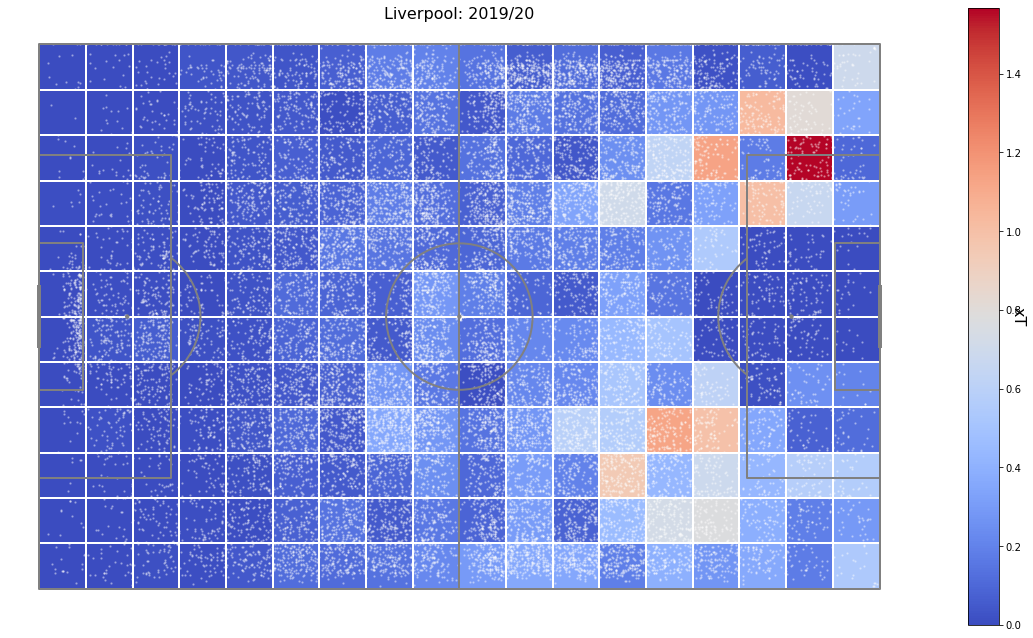

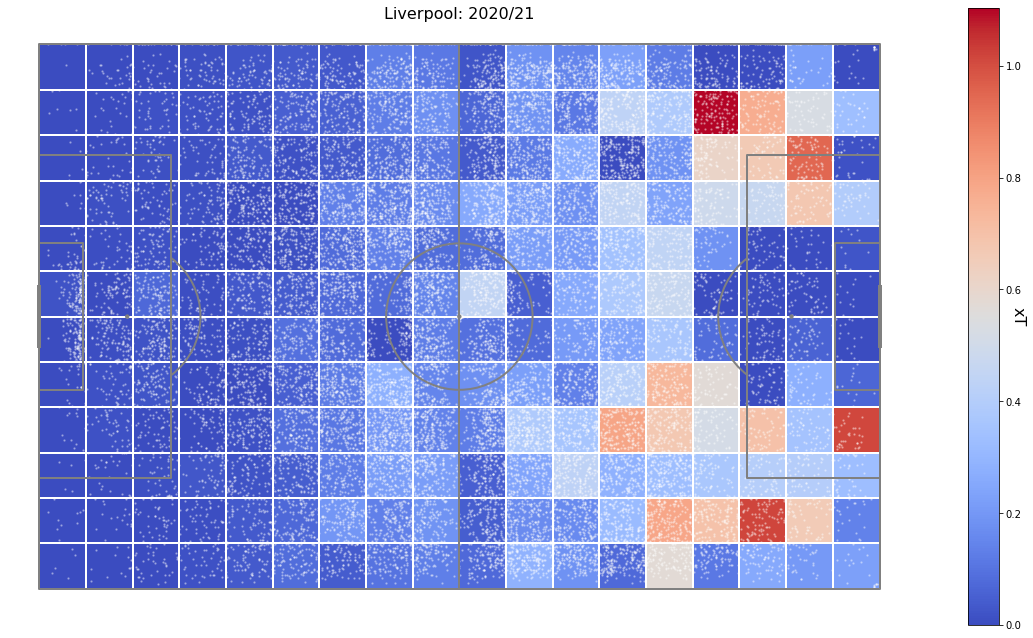

In [14]:
df_team = df_xT.loc[(df_xT['playerTeamId'] == 14)].reset_index(drop=True).copy()

for season in seasons:
        
    df_season = df_team.loc[df_team['season'] == season].reset_index(drop=True).copy()
    deltaxT.plot_xT_pitch(df_season, opta_events_relevant, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=None)
    

---

## **Delta xT**

CPU times: user 3min 16s, sys: 5.61 s, total: 3min 22s
Wall time: 1min 14s


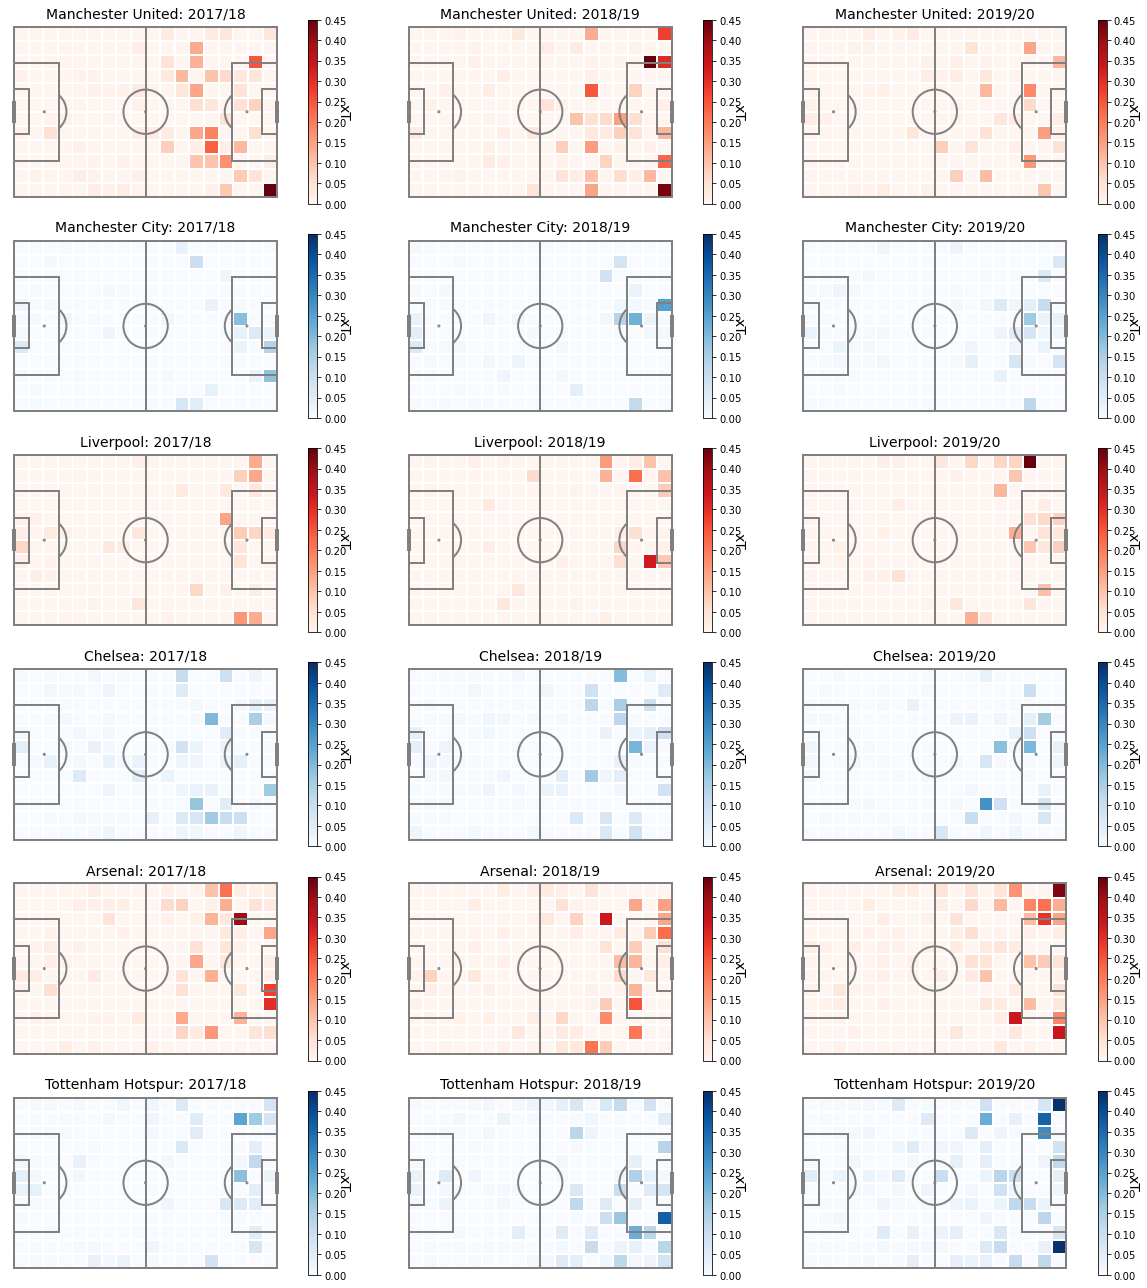

In [463]:
%%time

bins = (18,12)

pitch = Pitch(layout=(6, 3), pitch_type='opta', figsize=(18,18), pitch_color='white', line_zorder=2, line_color='gray')
fig, axs = pitch.draw()

vmax_override = 0.45

for ax, p in zip(axs.flat, lst_plots):
    
    team_id, season, c = p

    team_name = teams.loc[teams['homeTeamId'] == team_id, 'homeTeamName'].values[0]

    other_team_ids = df_matches.loc[(df_matches['seasonIndex'] == season) & (df_matches['homeTeamId'] == team_id), 'awayTeamId'].drop_duplicates().values

    # dataframe: matchId | homeTeamId | awayTeamId
    df_season_matches = df_matches.loc[df_matches['seasonIndex'] == season, ['matchId','homeTeamId','awayTeamId']].reset_index(drop=True)

    # code could be tidier but in a rush...
    season_name = df_matches.loc[df_matches['seasonIndex'] == season].reset_index(drop=True).season.values[0]

    # dict: {matchId: [home, away]}
    dic_matches = {i:[j,k] for i,j,k in zip(df_season_matches.matchId,df_season_matches.homeTeamId,df_season_matches.awayTeamId)}

    # looping through the matches
    vs_delta = np.zeros((bins[1], bins[0]))

    for opp_team_id in other_team_ids:

        # each opposition team will have two grids to store the xT counts
        vs_team = np.zeros((bins[1], bins[0]))
        vs_other = np.zeros((bins[1], bins[0]))

        # getting lists of match ids for the other teams, separating out the matches vs inter and the matches vs other teams
        ## getting the frequencies, too, as we'll use those to average things out later
        opp_team_matches_vs_team = [i for i in dic_matches.keys() if opp_team_id in dic_matches[i] and team_id in dic_matches[i]]
        freq_vs_team = len(opp_team_matches_vs_team)

        opp_team_matches_vs_other = [i for i in dic_matches.keys() if opp_team_id in dic_matches[i] and team_id not in dic_matches[i]]
        freq_vs_other = len(opp_team_matches_vs_other)

        ## starting with 
        for match_id in opp_team_matches_vs_team:
            df_xT_match =  df_opta_m.loc[(df_opta_m['matchId'] == match_id) & (df_opta_m['playerTeamId'] == opp_team_id)].copy()
            vs_team += pitch.bin_statistic(df_xT_match.x1, df_xT_match.y1, df_xT_match.xT, statistic='sum', bins=bins)['statistic']

        for match_id in opp_team_matches_vs_other:
            df_xT_match =  df_opta_m.loc[(df_opta_m['matchId'] == match_id) & (df_opta_m['playerTeamId'] == opp_team_id)].copy()
            vs_other += pitch.bin_statistic(df_xT_match.x1, df_xT_match.y1, df_xT_match.xT, statistic='sum', bins=bins)['statistic']

        # calculating averages
        mean_vs_team = vs_team / freq_vs_team
        mean_vs_other = vs_other / freq_vs_other

        # adding to delta
        vs_delta += (mean_vs_team - mean_vs_other)

    # providing overlay - the statistics here don't matter - we'll override these soon
    team_bin_statistic = pitch.bin_statistic(df_xT_match.x2, df_xT_match.y2, df_xT_match.xT, statistic='sum', bins=bins)

    # overriding single match with the aggregated delta
    team_bin_statistic['statistic'] = vs_delta

    # setting the colour scale
    vmax = team_bin_statistic['statistic'].max()
    vmin = 0

    # plotting the heatmap
    team_pcm = pitch.heatmap(team_bin_statistic, ax=ax, cmap=c, edgecolors='white', vmin=vmin, vmax=vmax_override)
    team_cbar = fig.colorbar(team_pcm, ax=ax)
    team_cbar.set_label('xT', rotation=270, fontsize=14)
    ax.set_title(f'{team_name}: {season_name}', x=0.5, y=0.98, fontsize=14, color='black')

fig.savefig('Top_6_Delta_xT.png', transparent=True, dpi=300)
